# 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

# 1. 데이터 로드

In [2]:
df = pd.read_excel('../데이터/최종본.xlsx')
df.head()

,year,month,day,ws,ta,hm,rn,result
0,2019,1,1,3.0,4.1,36,0.0,0
1,2019,1,2,3.9,4.2,30,0.0,1
2,2019,1,3,5.1,5.3,20,0.0,1
3,2019,1,4,5.8,6.3,20,0.0,0
4,2019,1,5,4.4,7.0,40,0.0,1


In [3]:
result_counts = df['result'].value_counts(normalize=True) * 100  # 비율(%)
print("result 0과 1의 비율:")
print(result_counts)

result 0과 1의 비율:
result
0    75.945205
1    24.054795
Name: proportion, dtype: float64


# 2. 특징과 레이블 선택

In [4]:
df_encoded = pd.get_dummies(df, columns=['year', 'month', 'day'], prefix=['year', 'month', 'day'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 53 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ws         1825 non-null   float64
 1   ta         1825 non-null   float64
 2   hm         1825 non-null   int64  
 3   rn         1825 non-null   float64
 4   result     1825 non-null   int64  
 5   year_2019  1825 non-null   bool   
 6   year_2020  1825 non-null   bool   
 7   year_2021  1825 non-null   bool   
 8   year_2022  1825 non-null   bool   
 9   year_2023  1825 non-null   bool   
 10  month_1    1825 non-null   bool   
 11  month_2    1825 non-null   bool   
 12  month_3    1825 non-null   bool   
 13  month_4    1825 non-null   bool   
 14  month_5    1825 non-null   bool   
 15  month_6    1825 non-null   bool   
 16  month_7    1825 non-null   bool   
 17  month_8    1825 non-null   bool   
 18  month_9    1825 non-null   bool   
 19  month_10   1825 non-null   bool   
 20  month_11

In [5]:
X = df_encoded.drop(columns=['result'])  # result 열을 제외한 모든 열
y = df_encoded['result']  # 레이블

# 3. 데이터 분할
(훈련/검증 세트, 비율: 90:10)   

In [6]:
# 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [8]:
import xgboost as xgb

In [9]:
model = xgb.XGBClassifier(n_estimators=100)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

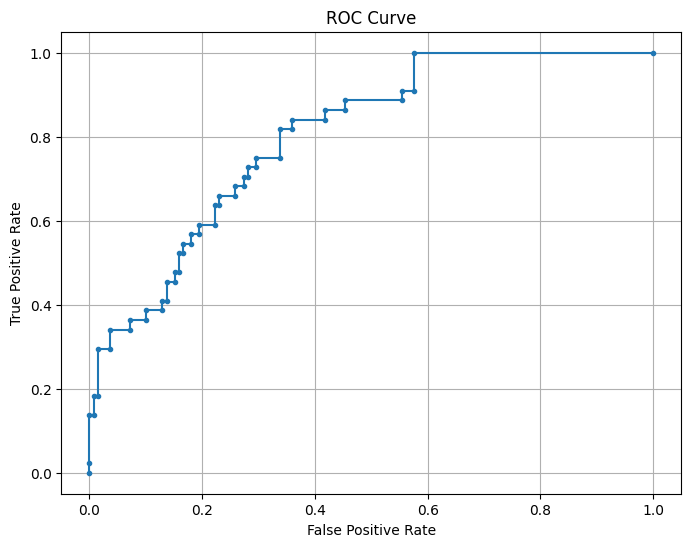

Optimal Threshold: 0.13871105015277863


In [10]:
import matplotlib.pyplot as plt

# 예측 확률
y_scores = model.predict_proba(X_test)[:, 1]

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

# 최적의 threshold 찾기 (TPR와 FPR의 차이가 가장 큰 지점)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# 5. 예측 및 평가

In [11]:
# 최적의 threshold를 사용하여 예측
y_val_pred = (y_scores >= optimal_threshold).astype(int)

# 모델 평가
print("검증 세트 정확도:", accuracy_score(y_test, y_val_pred))
print("검증 세트 ROC AUC 점수:", roc_auc_score(y_test, y_scores))
print("검증 세트 보고서:\n", classification_report(y_test, y_val_pred))

검증 세트 정확도: 0.6885245901639344
검증 세트 ROC AUC 점수: 0.8039568345323741
검증 세트 보고서:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76       139
           1       0.43      0.84      0.56        44

    accuracy                           0.69       183
   macro avg       0.68      0.74      0.66       183
weighted avg       0.81      0.69      0.71       183



In [12]:
test_pred = model.predict(X_test)

# 모델 평가
print("검증 세트 정확도:", accuracy_score(y_test, test_pred))
print("검증 세트 ROC AUC 점수:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print("검증 세트 보고서:\n", classification_report(y_test, test_pred))

검증 세트 정확도: 0.7595628415300546
검증 세트 ROC AUC 점수: 0.8039568345323741
검증 세트 보고서:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       139
           1       0.50      0.43      0.46        44

    accuracy                           0.76       183
   macro avg       0.66      0.65      0.65       183
weighted avg       0.75      0.76      0.75       183



In [11]:
test_pred_proba = model.predict_proba(X_test)[:, 1]  # 양성 클래스에 대한 확률

# 7. 테스트 세트와 예측 결과 출력
test_results = pd.DataFrame({
    '정답': y_test,
    '예측': test_pred,
    '예측 확률': test_pred_proba,
    '풍속 (ws)': X_test['ws'].values,
    '기온 (ta)': X_test['ta'].values,
    '습도 (hm)': X_test['hm'].values,
    '일일강수량 (rn)': X_test['rn'].values
})

In [12]:
print("\n테스트 세트 결과:")
test_results.sample(15)


테스트 세트 결과:


,정답,예측,예측 확률,풍속 (ws),기온 (ta),습도 (hm),일일강수량 (rn)
1017,0,0,0.25,2.3,25.6,60,0.0
907,0,0,0.39,3.2,27.4,60,0.0
543,1,1,0.51,2.5,28.0,61,0.0
650,0,0,0.06,2.9,22.4,50,0.0
1800,1,0,0.08,3.6,16.9,33,0.0
739,0,1,0.53,3.2,-2.6,30,0.0
1141,0,1,0.56,3.9,3.0,35,0.0
1748,1,0,0.20,6.4,21.6,43,0.0
1021,0,0,0.41,2.7,19.4,41,0.0
1094,0,0,0.38,4.9,2.2,25,0.0


# 6. 피처 중요도

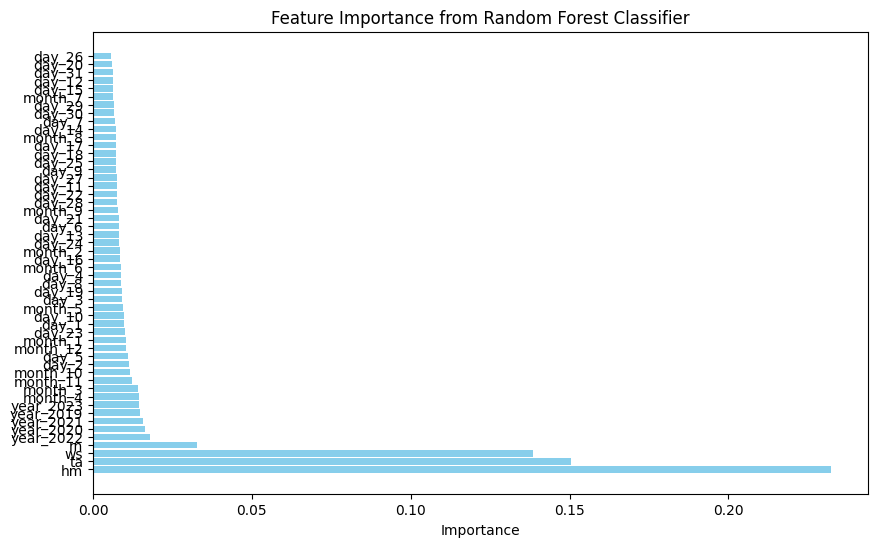

In [13]:
# 특성 중요도 가져오기
importances = model.feature_importances_

# 피처 이름과 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()